In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

## Section 1: Sanity Checks

### Learning

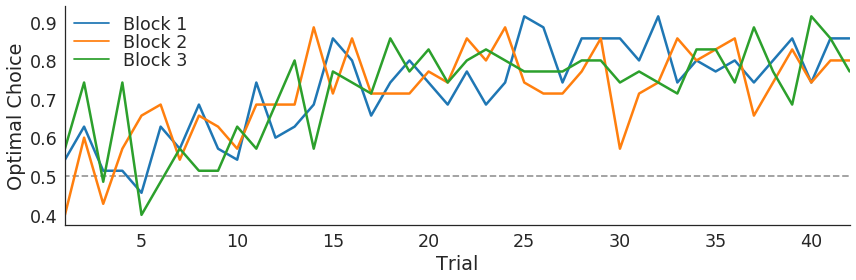

In [2]:
df = data[data.Block<4].copy()
df['Optimal'] = df.Choice == df[['M1','M2']].max(axis=1)
df.Block = ['Block %s' %s for s in df.Block]

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot('Trial', 'Optimal', 'Block', data=df, ci=None, lw=2.5, ax=ax)
ax.hlines(0.5, *ax.get_xlim(), linestyle='--', alpha=0.4)
ax.set(xlim=(1,42), ylabel='Optimal Choice')
ax.legend(loc=2, labelspacing=0, borderpad=0)

sns.despine()
plt.tight_layout()

### Subjective estimates of likelihood of win

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


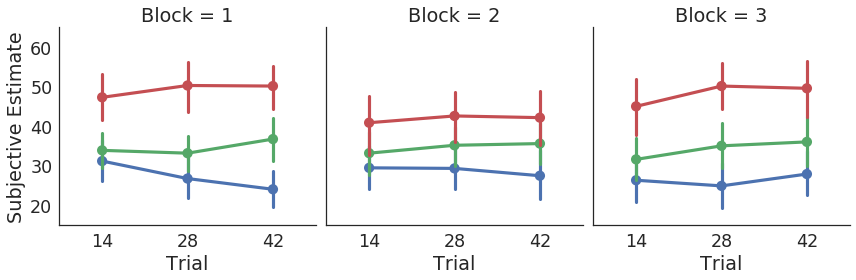

In [3]:
g = sns.FacetGrid(ratings[ratings.Variable!='Mood'], col='Block', size=4)
g.map(sns.pointplot, 'Trial', 'Rating', 'Variable', palette=['#4c72b0', '#55a868', '#c44e52'])
g.axes[0,0].set(ylim=(15,65), ylabel='Subjective Estimate');

### Wheel of fortune mood manipulation

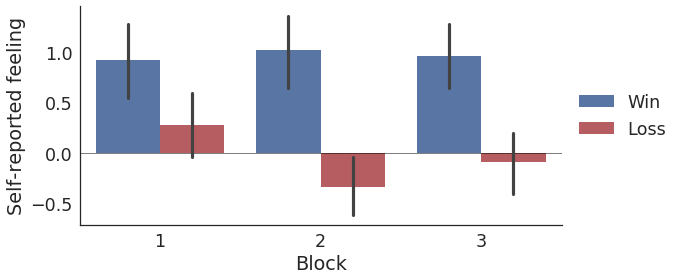

In [4]:

df = ratings.merge(metadata[['Subject','Datetime','WoF']], on=['Subject','Datetime'])
df['Outcome'] = np.where(df.WoF > 0, 'Win', 'Loss')

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot('Block', 'Rating', 'Outcome', data=df[df.Variable=='Mood'], 
            palette=['#4c72b0', '#c44e52'], ax=ax)

## Add info.
ax.set(ylabel='Self-reported feeling')
ax.hlines(0,*ax.get_xlim(),lw=0.5)
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5))

sns.despine()
plt.tight_layout()

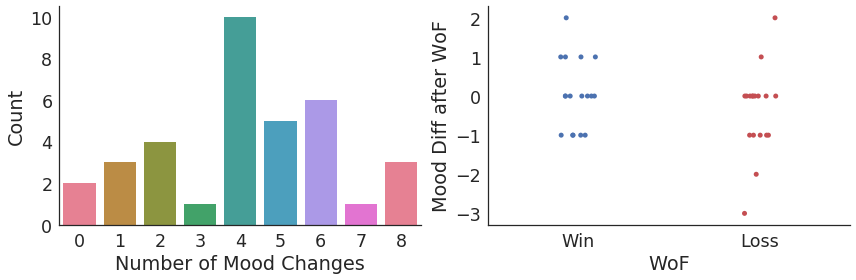

In [5]:
df = ratings[ratings.Variable=='Mood'].groupby('Datetime')
df = df.Rating.apply(np.diff).reset_index()
df = df.merge(metadata[['Datetime','WoF']], on='Datetime')
df['Shifts'] = df.Rating.apply(np.count_nonzero)
df['Diff'] = df.Rating.apply(lambda arr: arr[2])

fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot('Shifts', data=df, palette=sns.color_palette('husl', n_colors=df.Shifts.max()), ax=axes[0])
axes[0].set(xlabel='Number of Mood Changes', ylabel='Count')

sns.stripplot('WoF', 'Diff', data=df, order=[7,-7], palette=['#4c72b0', '#c44e52'], 
              jitter=True, ax=axes[1])
axes[1].set(xticklabels=['Win','Loss'], ylabel='Mood Diff after WoF')

sns.despine()
plt.tight_layout()

## Section 2: Model Fitting

### Choice of Priors
Priors inspired by [Gershman (2016)](http://www.sciencedirect.com/science/article/pii/S0022249616000080).

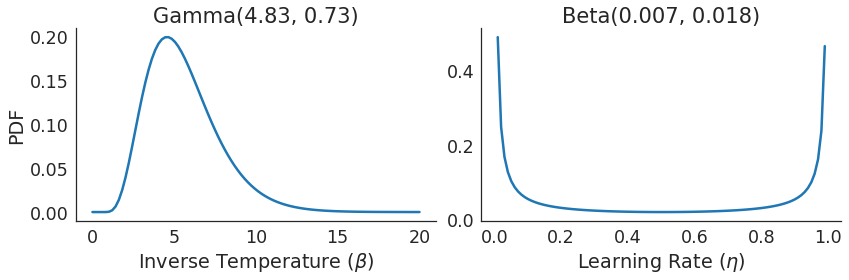

In [6]:
from scipy.stats import beta, gamma

g = gamma(4.83, 0.73)
b = beta(0.007, 0.018) 

fig, axes = plt.subplots(1,2,figsize=(12,4))

x = np.linspace(0,20,100)
axes[0].plot(x, g.pdf(x), lw=2.5)
axes[0].set(xlabel=r'Inverse Temperature ($\beta$)', ylabel='PDF', title='Gamma(4.83, 0.73)')

x = np.linspace(0,1,100)
axes[1].plot(x, b.pdf(x), lw=2.5)
axes[1].set(xlabel=r'Learning Rate ($\eta$)', title='Beta(0.007, 0.018)')

sns.despine()
plt.tight_layout()

### Base model: traditional reinforcement learning

In [32]:
import pystan

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subject parameters.
subjects = [0] # list of ints or all

## Model parameters.
q = 0

## Sampling parameters.
model_name = 'moodRL_base.stan'
samples = 2250
warmup = 2000
chains = 4
thin = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('n_samples = %0.0f' %((samples - warmup) * chains / thin))

## Define subjects.
subjects = data.Datetime.unique()[subjects]

## Main loop.
for datetime in subjects:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Reduce DataFrame.
    df = data[np.logical_and(data.Datetime==datetime, data.Block<4)].copy()
    
    ## Drop trials with missing data.
    df = df[df.Choice.notnull()]
    
    ## Extract and prepare data.
    X = df[['M1','M2']].values
    Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
    R = df.Outcome.values
    T = R.size
    
    ## Organize data dictionary.
    dd = dict(T=T, q=q, X=X, Y=Y, R=R)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                      chains=chains, seed=47404, n_jobs=1)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_058a7b43f0b1cb0acc80c655adb7b26d NOW.


n_samples = 1000


Inference for Stan model: anon_model_058a7b43f0b1cb0acc80c655adb7b26d.
4 chains, each with iter=2250; warmup=2000; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Beta   10.38    1.19   2.92   4.82   8.41   10.4  12.52  16.12      6   1.17
Eta_v   0.49    0.11   0.24   0.19   0.33   0.42   0.57    1.0      5   1.23
lp__  -64.98    0.76   2.15 -70.34 -65.49 -64.07  -63.5 -63.15      8   1.25

Samples were drawn using NUTS at Thu Dec 28 17:00:50 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


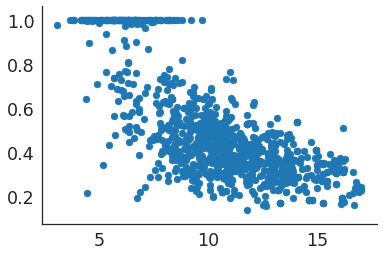

In [38]:
print(fit)
parameters = fit.extract()
plt.scatter(parameters['Beta'], parameters['Eta_v']);
sns.despine()